# Night shift planning

<b>Goal:</b> Implement algorithms to solve two variations of the night shift planning problem.

## Implementation 

The signatures of the functions to implement are given below. Note that for the programming part, we represent the $n$ nights by the set $N = \{0, 1, \ldots, n-1\}$, and the $q$ physicians by the set $P = \{0,1,\ldots,q-1\}$. It is clear from the context whether an integer refers to the corresponding night or the corresponding physician. Also check the inputs in the testing section below to see examples!

In [49]:
import matplotlib.pyplot as plt
import networkx as nx
import random

In [50]:
def schedule_graph(n, q, W, alpha, N, ub = None):
    G = nx.DiGraph()
    G.add_node('s')
    G.add_node('t')

    if None == ub:
        ub = n


    for physician in range(q):
        physician_node = 'p_{0}'.format(physician)
        G.add_edge('s', physician_node, capacity=min(alpha[physician], ub))
        for night_group in range(len(N)):
            night_group_node = 'p_{0}_n_{1}'.format(physician,night_group)
            G.add_edge(physician_node, night_group_node, capacity=2)
            for night in N[night_group]:
                if night in W[physician]:
                    G.add_edge(night_group_node, 'n_{0}'.format(night), capacity=1)

    for night in range(n):
        G.add_edge('n_{0}'.format(night), 't', capacity=2)

    return G
def schedule_a(n, q, W, alpha, N, ub = None):
    '''Finds a feasible assignment of nights to physicians.
    
    Args:
        n (int): Number of nights.
        q (int): Number of physicians.
        W: List indexed by physicians containing lists of nights when each
        physician is available.
        alpha: List indexed by physicians containing max number of nights each
        physician can be assigned.
        N: List of lists describing the partitioning of nights into blocks such
        that no physician can be assigned to more than 2 nights per block.
        ub: upper bound for number of nights per physician
    Returns:
        If there is a feasible assignment, returns a dict keyed by physicians
        containing lists of nights assigned to each physician. If there is no
        feasible assignment, returns None.
    '''

    G = schedule_graph(n,q,W,alpha,N, ub)
    ret = nx.maximum_flow(G,'s','t')
    if ret[0] == n * 2:
        ret_val = {}
        for physician in range(q):
            ret_val[physician] = []
            for night_group in range(len(N)):
                night_group_node = 'p_{0}_n_{1}'.format(physician,night_group)
                for nodes_with_flow in ret[1][night_group_node]:
                    if ret[1][night_group_node][nodes_with_flow] == 1:
                        ret_val[physician].append(int(nodes_with_flow[2:]))
        return ret_val


    # Add your implementation here
    return None

In [51]:
def schedule_b(n, q, W, alpha, N):
    '''Finds an assignment of nights to physicians that minimizes the maximum
    number of nights assigned to any physician.
    
    Args:
        n (int): Number of nights.
        q (int): Number of physicians.
        W: List indexed by physicians containing lists of nights when each
        physician is available.
        alpha: List indexed by physicians containing max number of nights each
        physician can be assigned.
        N: List of lists describing the partitioning of nights into blocks such
        that no physician can be assigned to more than 2 nights per block.

    Returns:
        If there is a feasible assignment, returns a dict keyed by physicians
        containing lists of nights assigned to each physician, minimizing the
        maximum number of nights assigned to any physician. If there is no
        feasible assignment, returns None.
    '''

    ub = n
    if len(alpha) > 0:
        ub = min(ub, max(alpha))

    result = None
    while True:
        temp_result = schedule_a(n, q, W, alpha, N, ub)

        if None == temp_result or ub == 0:
            break
        result = temp_result
        ub -= 1
    return result

---

## Testing

Below, we provide 10 example instances that you can test your implementations on.

You can use the `is_feasible( )` function below to test if the inputs that your implementation reports are feasible. Note that you'll obtain feedback on unsatisfied constraints, so you can double-check your solutions and your implementation accordingly!

Also, you can use the second function `test_schedule_ab( )` to test both of your implementations for (a) and (b) from above on the given example instances and compare to the expected outputs given below (as prepared in the cells further down). Be aware that the shift assignments are not unique, so you might see different assignments from those that we provide.

In [52]:
def is_feasible(n, q, W, alpha, N, assignment):
    '''Checks if the given assignment is feasible for the given instance.
    
    Args:
        n (int): Number of nights.
        q (int): Number of physicians.
        W: List indexed by physicians containing lists of nights when each
        physician is available.
        alpha: List indexed by physicians containing max number of nights each
        physician can be assigned.
        N: List of lists describing the partitioning of nights into blocks such
        that no physician can be assigned to more than 2 nights per block.
        assignment: Dict keyed by physicians containing lists of nights assigned
        to each physician.
    
    Returns:
        True if the given assignment is feasible for the given instance and
        False otherwise.
    '''
    if assignment is None:
        print('Assignment is empty.')
        return True
    
    k = len(N) # number of night blocks
    
    night_block = {}
    for l in range(k):
        for i in N[l]:
            night_block[i] = l
    
    night_physicians = [0] * n
    for j in range(q):
        shifts_per_block = [0] * k
        total_shifts = 0
        for night in assignment[j]:
            if night not in W[j]:
                print(f'Violation: Physician {j} is assigned night {night}, on which they are unavailable.')
                return False
            
            shifts_per_block[night_block[night]] += 1
            if shifts_per_block[night_block[night]] > 2:
                print(f'Violation: Physician {j} is assigned more than 2 shifts in block {night_block[night]}.')
                return False
            
            total_shifts += 1
            night_physicians[night] += 1
        
        if total_shifts > alpha[j]:
            print(f'Violation: Physician {j} is assigned {total_shifts} shifts, exceeding the limit of {alpha[j]}.')
            return False

    for i in range(n):
        if night_physicians[i] != 2:
            print(f'Violation: Night {i} is assigned {night_physicians[i]} instead of 2 physicians.')
            return False
    
    return True

In [53]:
def test_schedule_ab(n, q, W, alpha, N):
    '''Tests schedule_a() and schedule_b() on the given instance and prints information on the results of the test.
    
    Args:
        n (int): Number of nights.
        q (int): Number of physicians.
        W: List indexed by physicians containing lists of nights when each
        physician is available.
        alpha: List indexed by physicians containing max number of nights each
        physician can be assigned.
        N: List of lists describing the partitioning of nights into blocks such
        that no physician can be assigned to more than 2 nights per block.
        assignment: Dict keyed by physicians containing lists of nights assigned
        to each physician.
    
    Returns:
        None.
    '''
    res_a = schedule_a(n, q, W, alpha, N)
    print(f'Output assignment (part a): {res_a}')
    if res_a != None:
        feasible = is_feasible(n, q, W, alpha, N, res_a)
        print(f"Assignment is {'' if feasible else 'in'}feasible.")
        if feasible:
            print(f"The maximum number of nights per physician is {max([len(res_a.get(j, 0)) for j in range(q)], default=0)}.")
    else:
        print(f"Instance is infeasible.")
    
    print()
    
    res_b = schedule_b(n, q, W, alpha, N)
    print(f'Output assignment (part b): {res_b}')
    if res_a != None:
        feasible = is_feasible(n, q, W, alpha, N, res_b)
        print(f"Assignment is {'' if feasible else 'in'}feasible.")
        if feasible:
            print(f"The maximum number of nights per physician is {max([len(res_b.get(j, 0)) for j in range(q)], default=0)}.")
    else:
        print(f"Instance is infeasible.")

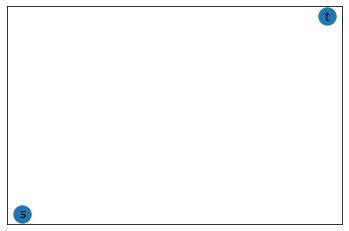

Output assignment (part a): {}
Assignment is feasible.
The maximum number of nights per physician is 0.

Output assignment (part b): None
Assignment is empty.
Assignment is feasible.
The maximum number of nights per physician is 0.


In [54]:
# Instance 1
# empty
n1 = 0
q1 = 0
W1 = []
alpha1 = []
N1 = []

# Auxiliary graph
nx.draw_networkx(schedule_graph(n1, q1, W1, alpha1, N1))
plt.show()

# Test
test_schedule_ab(n1, q1, W1, alpha1, N1)
# Expected output:
#  Output assignment (part a): {}
#  Assignment is feasible.
#  The maximum number of nights per physician is 0.
#  
#  Output assignment (part b): {}
#  Assignment is feasible.
#  The maximum number of nights per physician is 0.


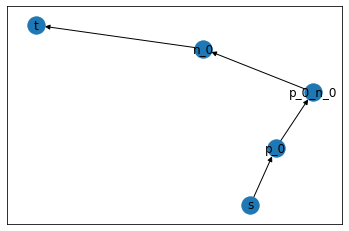

Output assignment (part a): None
Instance is infeasible.

Output assignment (part b): None
Instance is infeasible.


In [55]:
# Instance 2
# one physician, one night
n2 = 1
q2 = 1
k2 = 1
W2 = [[0]]
alpha2 = [2]
N2 = [[0]]

# Auxiliary graph
nx.draw_networkx(schedule_graph(n2, q2, W2, alpha2, N2))
plt.show()

# Test
test_schedule_ab(n2, q2, W2, alpha2, N2)
# Expected output:
#  Output assignment (part a): None
#  Instance is infeasible.
#  
#  Output assignment (part b): None
#  Instance is infeasible.

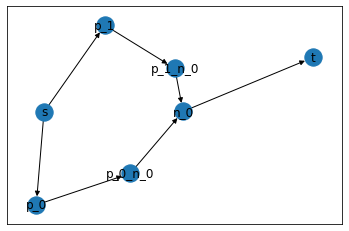

Output assignment (part a): {0: [0], 1: [0]}
Assignment is feasible.
The maximum number of nights per physician is 1.

Output assignment (part b): {0: [0], 1: [0]}
Assignment is feasible.
The maximum number of nights per physician is 1.


In [56]:
# Instance 3
# two physicians, one night
n3 = 1
q3 = 2
W3 = [[0], [0]]
alpha3 = [1, 1]
N3 = [[0]]

# Auxiliary graph
nx.draw_networkx(schedule_graph(n3, q3, W3, alpha3, N3))
plt.show()

# Test
test_schedule_ab(n3, q3, W3, alpha3, N3)
# Expected output:
#  Output assignment (part a): {0: [0], 1: [0]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 1.
#  
#  Output assignment (part b): {0: [0], 1: [0]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 1.

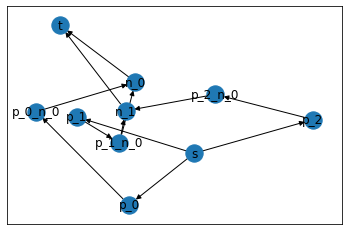

Output assignment (part a): {0: [0], 1: [0, 1], 2: [1]}
Assignment is feasible.
The maximum number of nights per physician is 2.

Output assignment (part b): {0: [0], 1: [0, 1], 2: [1]}
Assignment is feasible.
The maximum number of nights per physician is 2.


In [57]:
# Instance 4
# two nights, one physician with two shifts, two physicians with one shift each
n4 = 2
q4 = 3
W4 = [[0], [0, 1], [1]]
alpha4 = [2, 2, 2]
N4 = [[0, 1]]

# Auxiliary graph
nx.draw_networkx(schedule_graph(n4, q4, W4, alpha4, N4))
plt.show()

# Test
test_schedule_ab(n4, q4, W4, alpha4, N4)
# Expected output:
#  Output assignment (part a): {0: [0], 1: [0, 1], 2: [1]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 2.
#  
#  Output assignment (part b): {0: [0], 1: [0, 1], 2: [1]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 2.

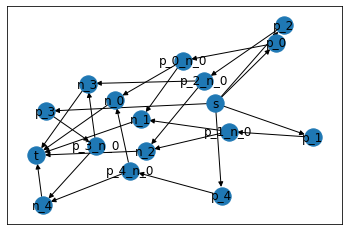

Output assignment (part a): {0: [0, 1], 1: [1, 2], 2: [2, 3], 3: [3, 4], 4: [0, 4]}
Assignment is feasible.
The maximum number of nights per physician is 2.

Output assignment (part b): {0: [0, 1], 1: [1, 2], 2: [2, 3], 3: [3, 4], 4: [0, 4]}
Assignment is feasible.
The maximum number of nights per physician is 2.


In [58]:
# Instance 5
# perfect 2:1 matching in one block
n5 = 5
q5 = 5
W5 = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 4]]
alpha5 = [2] * q5
N5 = [range(n5)]

# Auxiliary graph
nx.draw_networkx(schedule_graph(n5, q5, W5, alpha5, N5))
plt.show()

# Test
test_schedule_ab(n5, q5, W5, alpha5, N5)
# Expected output:
#  Output assignment (part a): {0: [0, 1], 1: [1, 2], 2: [2, 3], 3: [3, 4], 4: [0, 4]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 2.
#  
#  Output assignment (part b): {0: [0, 1], 1: [1, 2], 2: [2, 3], 3: [3, 4], 4: [0, 4]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 2.

In [59]:
# Instance 6
# perfect 2:1 matching in two blocks
n6 = 10
q6 = 5
W6 = [[0, 1, 5, 7], [1, 2, 7, 9], [2, 3, 9, 6], [3, 4, 6, 8], [0, 4, 8, 5]]
alpha6 = [10] * q6
N6 = [range(5), range(5, 10)]

# Auxiliary graph
# nx.draw_networkx(schedule_graph(n6, q6, W6, alpha6, N6))
# plt.show()

# Test
test_schedule_ab(n6, q6, W6, alpha6, N6)
# Expected output:
#  Output assignment (part a): {0: [0, 1, 5, 7], 1: [1, 2, 7, 9], 2: [2, 3, 6, 9], 3: [3, 4, 6, 8], 4: [0, 4, 5, 8]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 4.
#  
#  Output assignment (part b): {0: [0, 1, 5, 7], 1: [1, 2, 7, 9], 2: [2, 3, 6, 9], 3: [3, 4, 6, 8], 4: [0, 4, 5, 8]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 4.

Output assignment (part a): {0: [0, 1, 5, 7], 1: [1, 2, 7, 9], 2: [2, 3, 6, 9], 3: [3, 4, 6, 8], 4: [0, 4, 5, 8]}
Assignment is feasible.
The maximum number of nights per physician is 4.

Output assignment (part b): {0: [0, 1, 5, 7], 1: [1, 2, 7, 9], 2: [2, 3, 6, 9], 3: [3, 4, 6, 8], 4: [0, 4, 5, 8]}
Assignment is feasible.
The maximum number of nights per physician is 4.


In [60]:
# Instance 7
# three blocks, infeasible
n7 = 9
q7 = 5
W7 = [[0, 1, 2, 3], [1, 2, 3, 4], [3, 4, 5, 6], [5, 6, 7, 8], [7, 8, 9, 10]]
alpha7 = [4] * q7
N7 = [range(3), range(3, 6), range(6, 9)]

# Auxiliary graph
# nx.draw_networkx(schedule_graph(n7, q7, W7, alpha7, N7))
# plt.show()

# Test
test_schedule_ab(n7, q7, W7, alpha7, N7)
# Expected output:
#  Output assignment (part a): None
#  Instance is infeasible.
#  
#  Output assignment (part b): None
#  Instance is infeasible.

Output assignment (part a): None
Instance is infeasible.

Output assignment (part b): None
Instance is infeasible.


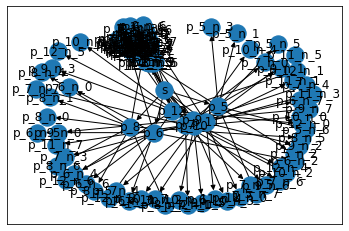

Output assignment (part a): {0: [], 1: [], 2: [], 3: [], 4: [0, 1, 2, 3, 4, 5, 6, 7], 5: [0], 6: [1], 7: [2], 8: [3], 9: [4], 10: [5], 11: [6], 12: [7]}
Assignment is feasible.
The maximum number of nights per physician is 8.

Output assignment (part b): {0: [6], 1: [5], 2: [3, 4], 3: [2, 7], 4: [0, 1], 5: [0], 6: [1], 7: [2], 8: [3], 9: [4], 10: [5], 11: [6], 12: [7]}
Assignment is feasible.
The maximum number of nights per physician is 2.


In [61]:
# Instance 8
# "one does all of them"
n8 = 8
q8 = 13
W8 = [[0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7], [0], [1], [2], [3], [4], [5], [6], [7]]
alpha8 = [10] * q8
N8 = [[0],[1],[2],[3],[4],[5],[6],[7]]

# Auxiliary graph
nx.draw_networkx(schedule_graph(n8, q8, W8, alpha8, N8))
plt.show()

# Test
test_schedule_ab(n8, q8, W8, alpha8, N8)
# Expected output:
#  Output assignment (part a): {0: [0, 1], 1: [1, 2], 2: [2, 3], 3: [3, 4], 4: [0, 4]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 2.
#  
#  Output assignment (part b): {0: [0, 1], 1: [1, 2], 2: [2, 3], 3: [3, 4], 4: [0, 4]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 2.

In [62]:
# Instance 9
# large random feasible
random.seed(9)
n9 = 15
q9 = 15
W9 = [random.sample(range(n9), random.randint(0, n9)) for j in range(q9)]
alpha9 = [random.randint(0, 10) for j in range(q9)]
N9 = [[] for l in range(4)]
for i in range(n9):
    random.choice(N9).append(i)

# Auxiliary graph
# nx.draw_networkx(schedule_graph(n9, q9, W9, alpha9, N9))
# plt.show()

# Test
test_schedule_ab(n9, q9, W9, alpha9, N9)
# Example output:
#  Output assignment (part a): {0: [2, 5, 8, 11, 13], 1: [7], 2: [], 3: [], 4: [], 5: [5, 10, 13], 6: [], 7: [0, 1, 8, 14], 8: [3], 9: [1], 10: [], 11: [2, 3, 6], 12: [4, 7, 12], 13: [6, 9], 14: [0, 4, 9, 10, 11, 12, 14]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 7.
#  
#  Output assignment (part b): {0: [2, 12, 13], 1: [11], 2: [], 3: [], 4: [], 5: [5, 9, 10], 6: [11, 12], 7: [0, 1, 8, 14], 8: [2, 3], 9: [1], 10: [], 11: [0, 5, 6, 7], 12: [3, 10, 13, 14], 13: [4, 6], 14: [4, 7, 8, 9]}
#  Assignment is feasible.
#  The maximum number of nights per physician is 4.

Output assignment (part a): {0: [4, 8, 10, 11, 13, 12], 1: [], 2: [], 3: [], 4: [], 5: [5, 10, 13, 6, 9], 6: [], 7: [14, 1, 8, 0], 8: [12], 9: [1], 10: [], 11: [2, 5, 3, 6], 12: [14, 3], 13: [7], 14: [2, 4, 0, 11, 7, 9]}
Assignment is feasible.
The maximum number of nights per physician is 6.

Output assignment (part b): {0: [2, 13, 7], 1: [14, 6], 2: [], 3: [], 4: [], 5: [5, 0, 6], 6: [3, 7, 12], 7: [14, 1, 8, 0], 8: [2, 11, 9], 9: [1], 10: [], 11: [5, 10, 9], 12: [4, 10, 13, 12], 13: [3], 14: [4, 8, 11]}
Assignment is feasible.
The maximum number of nights per physician is 4.


In [63]:
# Instance 10
# large random infeasible
random.seed(4)
n10 = 20
q10 = 20
W10 = [random.sample(range(n10), random.randint(0, 13)) for j in range(q10)]
alpha10 = [random.randint(0, 10) for j in range(q10)]
N10 = [[] for l in range(5)]
for i in range(n10):
    random.choice(N10).append(i)

# Auxiliary graph
# nx.draw_networkx(schedule_graph(n10, q10, W10, alpha10, N10))
# plt.show()

# Test
test_schedule_ab(n10, q10, W10, alpha10, N10)
# Example output:
#  Output assignment (part a): None
#  Instance is infeasible.
#  
#  Output assignment (part b): None
#  Instance is infeasible.

Output assignment (part a): None
Instance is infeasible.

Output assignment (part b): None
Instance is infeasible.


If you want to generate more testing instances, you can also change the seeds in the random instances above (or, of course, create your own)!